In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats

# Step 1: Read the CSV data
data = pd.read_csv('Water_Count.csv')

# Step 2: Combine 'Date' and 'Time' into a single datetime column
data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%m/%d/%Y %H:%M')

# Step 3: Sort data by datetime
data.sort_values('Datetime', inplace=True)

# Step 4: Reset index
data.reset_index(drop=True, inplace=True)

In [2]:
# Function to calculate cumulative working seconds
def calculate_working_seconds(datetimes):
    cumulative_seconds = []
    total_seconds = 0
    previous_datetime = datetimes.iloc[0]

    for current_datetime in datetimes:
        # Initialize working seconds for this interval
        working_seconds = 0
        temp_datetime = previous_datetime

        while temp_datetime < current_datetime:
            # Skip weekends
            if temp_datetime.weekday() >= 5:
                temp_datetime += timedelta(days=(7 - temp_datetime.weekday()))
                temp_datetime = temp_datetime.replace(hour=6, minute=0, second=0)
                continue

            # If before working hours, move to 6 AM
            if temp_datetime.hour < 6:
                temp_datetime = temp_datetime.replace(hour=6, minute=0, second=0)

            # If after working hours, move to next day at 6 AM
            if temp_datetime.hour >= 18:
                temp_datetime += timedelta(days=1)
                temp_datetime = temp_datetime.replace(hour=6, minute=0, second=0)
                continue

            # Calculate time until end of working hours or until current_datetime
            end_of_work_day = temp_datetime.replace(hour=18, minute=0, second=0)
            next_time_point = min(current_datetime, end_of_work_day)
            delta = (next_time_point - temp_datetime).total_seconds()
            working_seconds += delta
            temp_datetime = next_time_point

            # If we've reached end of working hours, move to next day
            if temp_datetime >= end_of_work_day:
                temp_datetime += timedelta(days=1)
                temp_datetime = temp_datetime.replace(hour=6, minute=0, second=0)

        total_seconds += working_seconds
        cumulative_seconds.append(total_seconds)
        previous_datetime = current_datetime

    return cumulative_seconds

# Apply the function to compute cumulative working seconds
data['Cumulative_Working_Seconds'] = calculate_working_seconds(data['Datetime'])

In [3]:
# Prepare data for regression
X = data['Cumulative_Working_Seconds'].values.reshape(-1, 1)  # Independent variable
y = data['Count'].values  # Dependent variable

# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [4]:
# Predict when the counter will reach 69,420
target_count = 69420

# Extract model parameters
m = model.coef_[0]
b = model.intercept_

# Calculate the cumulative working seconds needed to reach the target count
cumulative_seconds_to_target = (target_count - b) / m

# Calculate the additional working seconds needed from the last data point
additional_working_seconds_needed = cumulative_seconds_to_target - data['Cumulative_Working_Seconds'].iloc[-1]

In [5]:
# Function to add working seconds to a datetime
def add_working_seconds(start_datetime, seconds):
    current_datetime = start_datetime
    remaining_seconds = seconds

    while remaining_seconds > 0:
        # Skip weekends
        if current_datetime.weekday() >= 5:
            current_datetime += timedelta(days=(7 - current_datetime.weekday()))
            current_datetime = current_datetime.replace(hour=6, minute=0, second=0)
            continue

        # If after working hours, move to next day at 6 AM
        if current_datetime.hour >= 18:
            current_datetime += timedelta(days=1)
            current_datetime = current_datetime.replace(hour=6, minute=0, second=0)
            continue

        # If before working hours, move to 6 AM
        if current_datetime.hour < 6:
            current_datetime = current_datetime.replace(hour=6, minute=0, second=0)

        # Calculate time until end of working hours
        end_of_work_day = current_datetime.replace(hour=18, minute=0, second=0)
        time_available = (end_of_work_day - current_datetime).total_seconds()

        time_to_add = min(remaining_seconds, time_available)
        current_datetime += timedelta(seconds=time_to_add)
        remaining_seconds -= time_to_add

        # If we've reached end of working hours, move to next day
        if current_datetime >= end_of_work_day:
            current_datetime += timedelta(days=1)
            current_datetime = current_datetime.replace(hour=6, minute=0, second=0)

    return current_datetime

# Get the last timestamp in data
last_datetime = data['Datetime'].iloc[-1]

# Adjust last_datetime if it's outside working hours
if last_datetime.hour >= 18:
    last_datetime += timedelta(days=1)
    last_datetime = last_datetime.replace(hour=6, minute=0, second=0)
elif last_datetime.hour < 6:
    last_datetime = last_datetime.replace(hour=6, minute=0, second=0)

# Adjust for weekends
if last_datetime.weekday() >= 5:
    last_datetime += timedelta(days=(7 - last_datetime.weekday()))
    last_datetime = last_datetime.replace(hour=6, minute=0, second=0)

# Calculate the predicted datetime
predicted_datetime = add_working_seconds(last_datetime, additional_working_seconds_needed)

print(f"The counter is predicted to reach {target_count} on {predicted_datetime.strftime('%Y-%m-%d %H:%M')}")

The counter is predicted to reach 69420 on 2024-11-14 15:53


In [6]:
# Calculate residuals
predictions = model.predict(X)
residuals = y - predictions

# Degrees of freedom
df = len(y) - 2  # Number of observations minus number of parameters

# Residual standard error
s_e = np.sqrt(np.sum(residuals**2) / df)

# t-statistic for 95% confidence
t = stats.t.ppf(0.975, df)

# Standard error of the predicted x (cumulative working seconds)
mean_X = np.mean(X)
Sxx = np.sum((X - mean_X)**2)
s_x = s_e / np.abs(m) * np.sqrt(1 + (1/len(X)) + ((cumulative_seconds_to_target - mean_X)**2 / Sxx))

# Prediction interval for x (cumulative_seconds_to_target)
delta_seconds = t * s_x

# Lower and upper bounds for the predicted cumulative working seconds
cumulative_seconds_lower = cumulative_seconds_to_target - delta_seconds
cumulative_seconds_upper = cumulative_seconds_to_target + delta_seconds

# Calculate the additional working seconds needed from the last data point
additional_working_seconds_lower = cumulative_seconds_lower - data['Cumulative_Working_Seconds'].iloc[-1]
additional_working_seconds_upper = cumulative_seconds_upper - data['Cumulative_Working_Seconds'].iloc[-1]

# Calculate the lower and upper predicted datetimes
predicted_datetime_lower = add_working_seconds(last_datetime, additional_working_seconds_lower)
predicted_datetime_upper = add_working_seconds(last_datetime, additional_working_seconds_upper)

print(f"With 95% confidence, the counter will reach {target_count} between {predicted_datetime_lower.strftime('%Y-%m-%d %H:%M')} and {predicted_datetime_upper.strftime('%Y-%m-%d %H:%M')}")

With 95% confidence, the counter will reach 69420 between 2024-11-13 15:16 and 2024-11-15 16:30


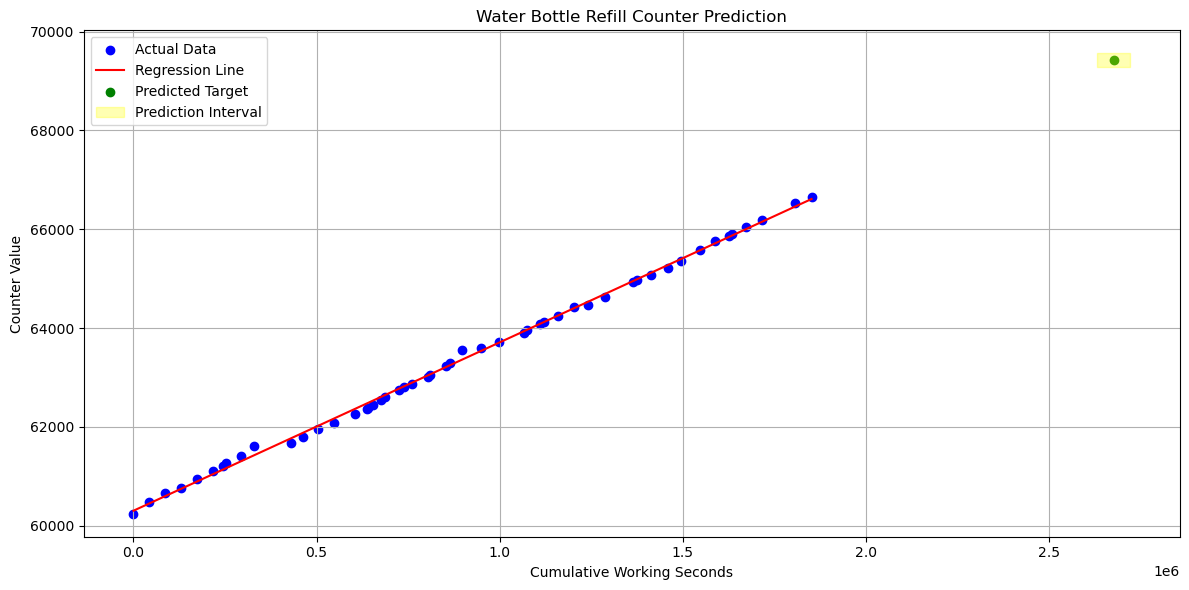

In [7]:
# Plotting the data and regression line
plt.figure(figsize=(12,6))

# Plot actual data points
plt.scatter(data['Cumulative_Working_Seconds'], y, color='blue', label='Actual Data')

# Plot regression line
plt.plot(data['Cumulative_Working_Seconds'], predictions, color='red', label='Regression Line')

# Plot the predicted target point
plt.scatter(cumulative_seconds_to_target, target_count, color='green', label='Predicted Target')

# Plot prediction interval
plt.fill_between(
    [cumulative_seconds_lower, cumulative_seconds_upper],
    [target_count - t * s_e, target_count - t * s_e],
    [target_count + t * s_e, target_count + t * s_e],
    color='yellow', alpha=0.3, label='Prediction Interval'
)

# Formatting the plot
plt.xlabel('Cumulative Working Seconds')
plt.ylabel('Counter Value')
plt.title('Water Bottle Refill Counter Prediction')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()